# Лабораторная работа 3. Фильтрация рекомендаций фильмов

**Цель:** Использовать системы рекомендаций на основе машинного обучения для фильтрации фильмов.

## Теоретическое введение

**Системы рекомендаций** — это класс алгоритмов машинного обучения, которые помогают пользователям находить релевантный контент (фильмы, товары, музыку и т.д.).

### Коллаборативная фильтрация (Collaborative Filtering)

**Коллаборативная фильтрация** основана на предположении, что пользователи с похожими предпочтениями в прошлом будут иметь похожие предпочтения в будущем.

#### Основные подходы:

1. **User-based CF** — находим похожих пользователей и рекомендуем то, что им понравилось
2. **Item-based CF** — находим похожие фильмы и рекомендуем те, которые пользователь ещё не смотрел
3. **Matrix Factorization** — разложение матрицы рейтингов на низкоранговые матрицы пользователей и фильмов

### Матричная факторизация

Идея: представляем матрицу рейтингов R (users × movies) как произведение двух матриц:

**R ≈ P × Q^T**

где:
- **P** (n_users × k) — матрица скрытых признаков пользователей
- **Q** (n_movies × k) — матрица скрытых признаков фильмов
- **k** — размерность скрытого пространства (гиперпараметр)

### Метрики оценки

- **RMSE (Root Mean Squared Error)** — корень из среднего квадрата ошибок
- **MAE (Mean Absolute Error)** — средняя абсолютная ошибка

## Часть 1. Подготовка окружения и загрузка библиотек

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

  Using cached pandas-2.3.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached pandas-2.3.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.8 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.ma

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import os
import zipfile
import urllib.request
from collections import defaultdict

warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Для воспроизводимости
np.random.seed(42)

print("Библиотеки загружены успешно!")

Библиотеки загружены успешно!


## Часть 2. Загрузка и исследование данных MovieLens

In [7]:
# URL датасета MovieLens 100K (классический набор данных)
ML_100K_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATA_DIR = "data"
ZIP_FILE = os.path.join(DATA_DIR, "ml-100k.zip")
EXTRACT_DIR = os.path.join(DATA_DIR, "ml-100k")

def download_movielens():
    """
    Загружает датасет MovieLens 100K если его ещё нет
    """
    if os.path.exists(os.path.join(EXTRACT_DIR, "u.data")):
        print("Датасет уже загружен!")
        return
    
    os.makedirs(DATA_DIR, exist_ok=True)
    
    if not os.path.exists(ZIP_FILE):
        print("Загрузка датасета MovieLens 100K...")
        urllib.request.urlretrieve(ML_100K_URL, ZIP_FILE)
        print("Загрузка завершена!")
    
    if not os.path.exists(EXTRACT_DIR):
        print("Распаковка архива...")
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
        print("Распаковка завершена!")

download_movielens()

Загрузка датасета MovieLens 100K...
Загрузка завершена!
Распаковка архива...
Распаковка завершена!


In [8]:
# Загрузка данных о рейтингах
# Формат: user_id | movie_id | rating | timestamp
ratings_file = os.path.join(EXTRACT_DIR, "u.data")
ratings = pd.read_csv(ratings_file, sep='\t', header=None,
                     names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Загрузка информации о фильмах
# Формат: movie_id | title | release_date | video_release_date | imdb_url | ...
movies_file = os.path.join(EXTRACT_DIR, "u.item")
movies = pd.read_csv(movies_file, sep='|', header=None, encoding='latin-1',
                    usecols=[0, 1], names=['movie_id', 'title'])

print(f"Количество рейтингов: {len(ratings)}")
print(f"Количество уникальных пользователей: {ratings['user_id'].nunique()}")
print(f"Количество уникальных фильмов: {ratings['movie_id'].nunique()}")
print(f"\nПервые строки рейтингов:")
print(ratings.head())
print(f"\nПервые строки фильмов:")
print(movies.head())

Количество рейтингов: 100000
Количество уникальных пользователей: 943
Количество уникальных фильмов: 1682

Первые строки рейтингов:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

Первые строки фильмов:
   movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)


In [9]:
# Объединяем данные для удобства
df = ratings.merge(movies, on='movie_id')

print("Объединённый датасет:")
print(df.head(10))

Объединённый датасет:
   user_id  movie_id  rating  timestamp  \
0      196       242       3  881250949   
1      186       302       3  891717742   
2       22       377       1  878887116   
3      244        51       2  880606923   
4      166       346       1  886397596   
5      298       474       4  884182806   
6      115       265       2  881171488   
7      253       465       5  891628467   
8      305       451       3  886324817   
9        6        86       3  883603013   

                                               title  
0                                       Kolya (1996)  
1                           L.A. Confidential (1997)  
2                                Heavyweights (1994)  
3                         Legends of the Fall (1994)  
4                                Jackie Brown (1997)  
5  Dr. Strangelove or: How I Learned to Stop Worr...  
6                   Hunt for Red October, The (1990)  
7                            Jungle Book, The (1994)  
8        

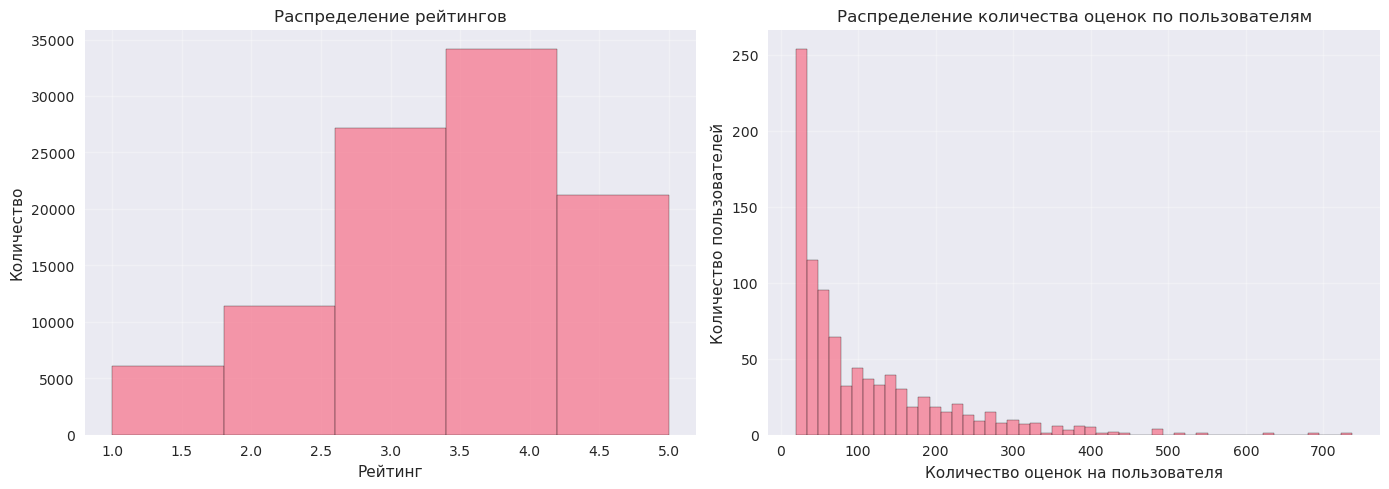


Статистика рейтингов:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [35]:
# Визуализация распределения рейтингов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма рейтингов
axes[0].hist(df['rating'], bins=5, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Рейтинг')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение рейтингов')
axes[0].grid(True, alpha=0.3)

# Статистика по пользователям
user_ratings_count = df.groupby('user_id').size()
axes[1].hist(user_ratings_count, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Количество оценок на пользователя')
axes[1].set_ylabel('Количество пользователей')
axes[1].set_title('Распределение количества оценок по пользователям')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистика рейтингов:")
print(df['rating'].describe())

## Задание 1: Реализация коллаборативной фильтрации

Реализуем матричную факторизацию (Matrix Factorization) для предсказания рейтингов.

In [11]:
class MatrixFactorization:
    """
    Реализация коллаборативной фильтрации через матричную факторизацию.
    
    Использует стохастический градиентный спуск (SGD) для оптимизации.
    """
    
    def __init__(self, n_factors=50, learning_rate=0.01, reg=0.01, n_epochs=20, random_state=42):
        """
        Args:
            n_factors: размерность скрытого пространства (количество факторов)
            learning_rate: скорость обучения
            reg: коэффициент регуляризации (L2)
            n_epochs: количество эпох обучения
            random_state: seed для воспроизводимости
        """
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.reg = reg
        self.n_epochs = n_epochs
        self.random_state = random_state
        
    def fit(self, ratings_df):
        """
        Обучает модель на данных рейтингов.
        
        Args:
            ratings_df: DataFrame с колонками ['user_id', 'movie_id', 'rating']
        """
        # Создаём маппинги user_id и movie_id в индексы 0..n-1
        self.user_ids = ratings_df['user_id'].unique()
        self.movie_ids = ratings_df['movie_id'].unique()
        
        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(self.user_ids)}
        self.movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(self.movie_ids)}
        
        self.idx_to_user = {idx: user_id for user_id, idx in self.user_to_idx.items()}
        self.idx_to_movie = {idx: movie_id for movie_id, idx in self.movie_to_idx.items()}
        
        n_users = len(self.user_ids)
        n_movies = len(self.movie_ids)
        
        # Инициализация матриц P (пользователи) и Q (фильмы) случайными значениями
        np.random.seed(self.random_state)
        self.P = np.random.normal(0, 0.1, (n_users, self.n_factors))  # User factors
        self.Q = np.random.normal(0, 0.1, (n_movies, self.n_factors))  # Movie factors
        
        # Средний рейтинг (базовая линия)
        self.global_mean = ratings_df['rating'].mean()
        
        # Смещения пользователей и фильмов (bias)
        self.user_bias = np.zeros(n_users)
        self.movie_bias = np.zeros(n_movies)
        
        # История ошибок для визуализации
        self.train_errors = []
        
        # Конвертируем DataFrame в numpy массивы для быстрой обработки
        user_indices = ratings_df['user_id'].map(self.user_to_idx).values
        movie_indices = ratings_df['movie_id'].map(self.movie_to_idx).values
        ratings_values = ratings_df['rating'].values
        
        # Обучение методом стохастического градиентного спуска
        for epoch in range(self.n_epochs):
            # Перемешиваем данные для каждой эпохи
            indices = np.arange(len(ratings_values))
            np.random.shuffle(indices)
            
            epoch_error = 0
            
            for idx in indices:
                u = user_indices[idx]
                i = movie_indices[idx]
                r = ratings_values[idx]
                
                # Предсказание: r̂ = μ + b_u + b_i + p_u · q_i
                prediction = self.global_mean + self.user_bias[u] + self.movie_bias[i] + \
                            np.dot(self.P[u], self.Q[i])
                
                # Ошибка: e = r - r̂
                error = r - prediction
                epoch_error += error ** 2
                
                # Обновление параметров (градиентный спуск)
                # Обновляем смещения
                self.user_bias[u] += self.learning_rate * (error - self.reg * self.user_bias[u])
                self.movie_bias[i] += self.learning_rate * (error - self.reg * self.movie_bias[i])
                
                # Обновляем факторы пользователя и фильма
                P_u_old = self.P[u].copy()
                self.P[u] += self.learning_rate * (error * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += self.learning_rate * (error * P_u_old - self.reg * self.Q[i])
            
            # Средняя ошибка за эпоху
            epoch_error = np.sqrt(epoch_error / len(ratings_values))
            self.train_errors.append(epoch_error)
            
            if (epoch + 1) % 5 == 0:
                print(f"Эпоха {epoch + 1}/{self.n_epochs}, RMSE: {epoch_error:.4f}")
    
    def predict(self, user_id, movie_id):
        """
        Предсказывает рейтинг для заданного пользователя и фильма.
        
        Args:
            user_id: ID пользователя
            movie_id: ID фильма
        
        Returns:
            Предсказанный рейтинг (ограниченный диапазоном 1-5)
        """
        if user_id not in self.user_to_idx or movie_id not in self.movie_to_idx:
            # Если пользователь или фильм не были в обучающей выборке, возвращаем средний рейтинг
            return self.global_mean
        
        u = self.user_to_idx[user_id]
        i = self.movie_to_idx[movie_id]
        
        prediction = self.global_mean + self.user_bias[u] + self.movie_bias[i] + \
                    np.dot(self.P[u], self.Q[i])
        
        # Ограничиваем рейтинг диапазоном [1, 5]
        return np.clip(prediction, 1, 5)
    
    def predict_batch(self, user_ids, movie_ids):
        """
        Предсказывает рейтинги для батча пользователей и фильмов.
        """
        predictions = []
        for user_id, movie_id in zip(user_ids, movie_ids):
            predictions.append(self.predict(user_id, movie_id))
        return np.array(predictions)

In [ ]:
# ============================================================================
# РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST
# ============================================================================
# Важно: модель обучается на train, оценивается на test
# Это позволяет оценить способность модели к обобщению на новые данные
# random_state=42 - для воспроизводимости результатов

train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)
# 80% данных (80000 рейтингов) - для обучения
# 20% данных (20000 рейтингов) - для тестирования

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")
print(f"\nПервые строки обучающей выборки:")
print(train_df.head())

Размер обучающей выборки: 80000
Размер тестовой выборки: 20000

Первые строки обучающей выборки:
       user_id  movie_id  rating  timestamp
75220      807      1411       1  893082619
48955      474       659       5  887925187
44966      463       268       4  877384940
13568      139       286       4  879537844
92727      621       751       4  883799651


In [ ]:
# СОЗДАНИЕ И ОБУЧЕНИЕ БАЗОВОЙ МОДЕЛИ
# Гиперпараметры матричной факторизации:
# - n_factors: размерность скрытого пространства (сколько "скрытых вкусов" у пользователей)
# - learning_rate: шаг градиентного спуска (большой = быстро, но нестабильно)
# - reg: регуляризация L2 (предотвращает переобучение)
# - n_epochs: сколько раз пройти по всем данным

print("Создание модели матричной факторизации...")
print(f"Параметры: n_factors={50}, learning_rate={0.01}, reg={0.01}, n_epochs={20}")
print("\n" + "="*60)

model = MatrixFactorization(
    n_factors=50,       # 50 скрытых факторов 
    learning_rate=0.01, # Скорость обучения
    reg=0.01,           # Слабая регуляризация 
    n_epochs=20         # 20 проходов по данным
)

# Обучение модели на train данных
# Модель учится предсказывать рейтинги: r̂ = μ + b_u + b_i + p_u · q_i
model.fit(train_df)

print("\n" + "="*60)
print("Обучение завершено!")

Создание модели матричной факторизации...
Параметры: n_factors=50, learning_rate=0.01, reg=0.01, n_epochs=20

Эпоха 5/20, RMSE: 0.8956
Эпоха 10/20, RMSE: 0.7853
Эпоха 15/20, RMSE: 0.6524
Эпоха 20/20, RMSE: 0.5493

Обучение завершено!


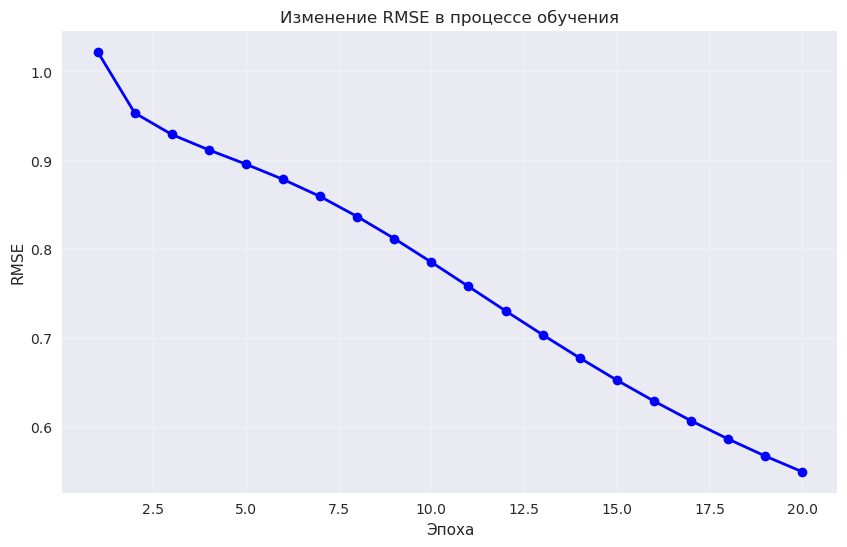

Начальный RMSE: 1.0223
Финальный RMSE: 0.5493
Улучшение: 46.27%


In [14]:
# Визуализация процесса обучения
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model.train_errors) + 1), model.train_errors, 'b-', linewidth=2, marker='o')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.title('Изменение RMSE в процессе обучения')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Начальный RMSE: {model.train_errors[0]:.4f}")
print(f"Финальный RMSE: {model.train_errors[-1]:.4f}")
print(f"Улучшение: {((model.train_errors[0] - model.train_errors[-1]) / model.train_errors[0] * 100):.2f}%")

## Задание 2: Оценка точности рекомендаций

Оценим качество модели с помощью метрик RMSE и MAE.

In [28]:

# ОЦЕНКА МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ


print("Генерация предсказаний для тестовой выборки...")

# Получаем предсказания для всех пар (user, movie) из тестовой выборки
test_predictions = model.predict_batch(test_df['user_id'].values, test_df['movie_id'].values)
test_actual = test_df['rating'].values  # Реальные рейтинги

# Вычисление метрик качества
# RMSE - штрафует большие ошибки сильнее (из-за квадрата)
rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))
# MAE - средняя абсолютная ошибка, более интерпретируемая
mae = mean_absolute_error(test_actual, test_predictions)

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛИ")
print("="*60)
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print("="*60)

# Интерпретация результатов
print(f"\nИнтерпретация модели:")
print(f"- RMSE = {rmse:.4f} означает, что в среднем предсказания отклоняются от реальных рейтингов на {rmse:.2f} балла")
print(f"- MAE = {mae:.4f} означает среднюю абсолютную ошибку {mae:.2f} балла")

Генерация предсказаний для тестовой выборки...

РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛИ
RMSE (Root Mean Squared Error): 0.9714
MAE (Mean Absolute Error): 0.7594

Интерпретация модели:
- RMSE = 0.9714 означает, что в среднем предсказания отклоняются от реальных рейтингов на 0.97 балла
- MAE = 0.7594 означает среднюю абсолютную ошибку 0.76 балла


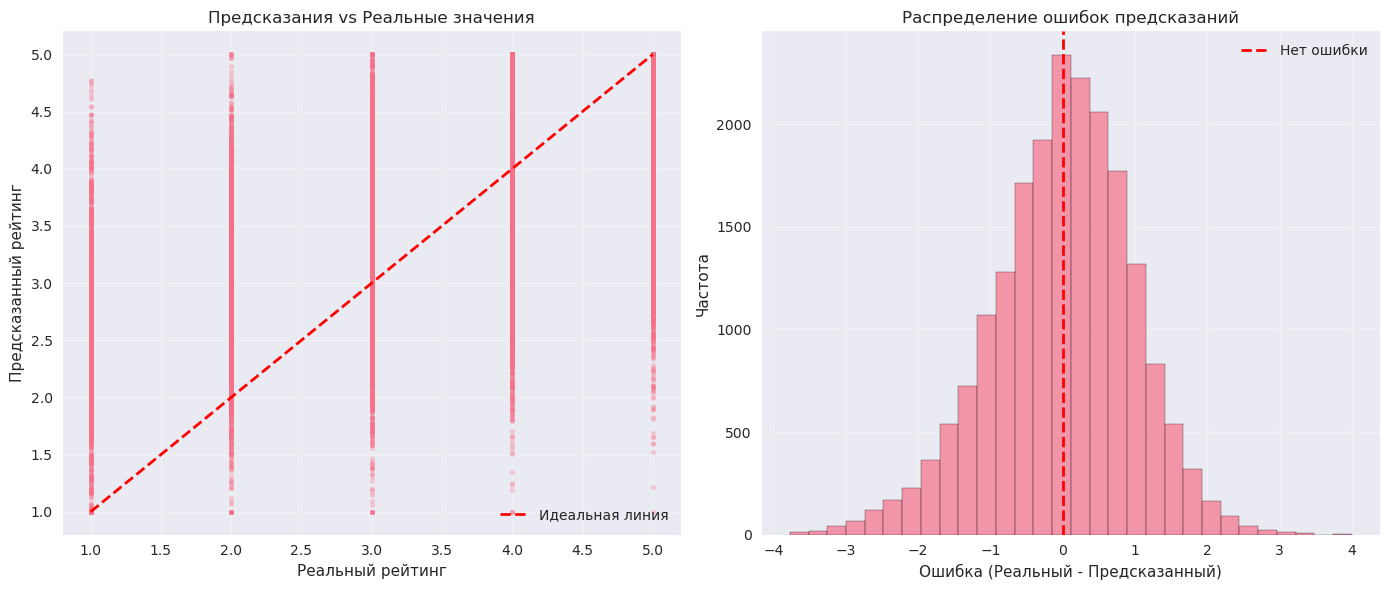


Статистика ошибок:
Средняя ошибка: -0.0075
Стандартное отклонение: 0.9714
Медианная ошибка: 0.0420


In [ ]:

# ВИЗУАЛИЗАЦИЯ КАЧЕСТВА ПРЕДСКАЗАНИЙ


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Левый график: Scatter plot предсказаний vs реальных значений
# Идеальная модель: все точки лежат на диагонали y=x
axes[0].scatter(test_actual, test_predictions, alpha=0.3, s=10)
axes[0].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Идеальная линия (y=x)')
axes[0].set_xlabel('Реальный рейтинг')
axes[0].set_ylabel('Предсказанный рейтинг')
axes[0].set_title('Предсказания vs Реальные значения')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Правый график: Гистограмма ошибок
# Идеальная модель: все ошибки близки к 0 (узкий пик в центре)
errors = test_actual - test_predictions  # Положительная ошибка = занизили, отрицательная = завысили
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Ошибка (Реальный - Предсказанный)')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок предсказаний')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Нет ошибки')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика ошибок:
# - Средняя ошибка близка к 0 = нет систематического смещения
# - Стандартное отклонение = разброс ошибок (чем меньше, тем лучше)
# - Медианная ошибка = типичная ошибка для большинства предсказаний
print(f"\nСтатистика ошибок:")
print(f"Средняя ошибка: {errors.mean():.4f}")      # Должна быть близка к 0
print(f"Стандартное отклонение: {errors.std():.4f}") # Равно RMSE если средняя ≈ 0
print(f"Медианная ошибка: {np.median(errors):.4f}")  # Устойчива к выбросам

In [ ]:

# УЛУЧШЕННАЯ МОДЕЛЬ: борьба с переобучением

# Изменения:
# 1. Увеличена регуляризация (reg: 0.01 -> 0.1)
# 2. Уменьшено количество факторов (n_factors: 50 -> 30)
# 3. Уменьшен learning_rate для более стабильного обучения

print("="*60)
print("УЛУЧШЕННАЯ МОДЕЛЬ (с увеличенной регуляризацией)")
print("="*60)
print("Параметры: n_factors=30, learning_rate=0.005, reg=0.1, n_epochs=25")
print("="*60 + "\n")

model_improved = MatrixFactorization(
    n_factors=30,        # Меньше факторов - меньше переобучение
    learning_rate=0.005, # Медленнее учимся - стабильнее
    reg=0.1,             # Больше регуляризация - меньше переобучение
    n_epochs=25          # Чуть больше эпох для компенсации медленного обучения
)

model_improved.fit(train_df)

print("\n" + "="*60)
print("Обучение улучшенной модели завершено!")


УЛУЧШЕННАЯ МОДЕЛЬ (с увеличенной регуляризацией)
Параметры: n_factors=30, learning_rate=0.005, reg=0.1, n_epochs=25

Эпоха 5/25, RMSE: 0.9407
Эпоха 10/25, RMSE: 0.9213
Эпоха 15/25, RMSE: 0.9124
Эпоха 20/25, RMSE: 0.9052
Эпоха 25/25, RMSE: 0.8967

Обучение улучшенной модели завершено!


СРАВНЕНИЕ МОДЕЛЕЙ

📊 Сравнение результатов:
------------------------------------------------------------
Модель                                   RMSE       MAE       
------------------------------------------------------------
Базовая (n_factors=50, reg=0.01)         0.9714     0.7594    
Улучшенная (n_factors=30, reg=0.1)       0.9373     0.7411    
------------------------------------------------------------


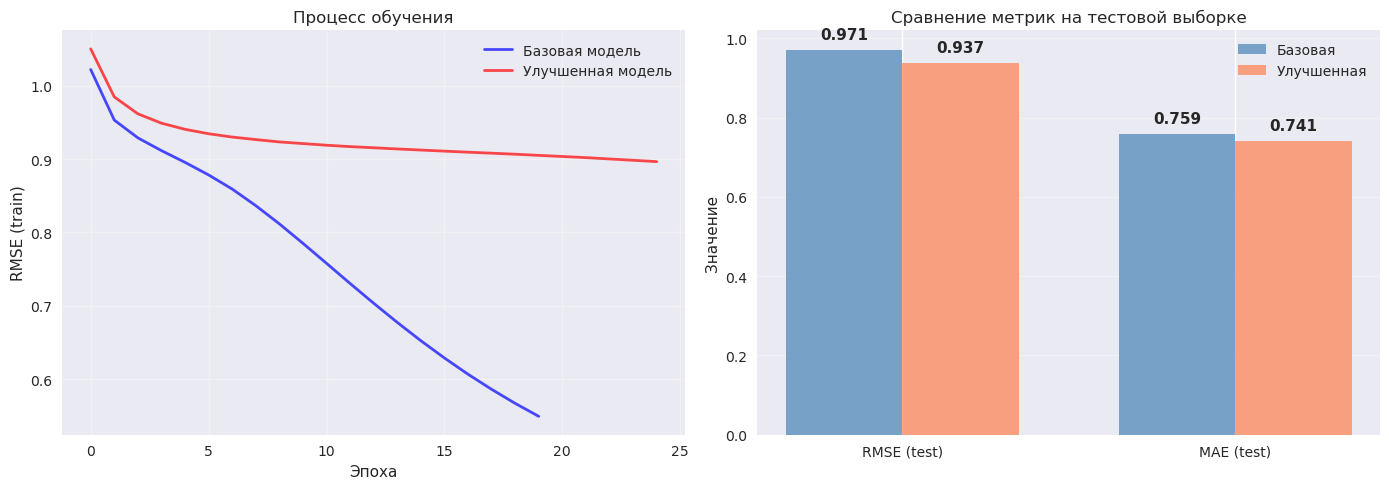


✅ Улучшенная модель лучше на 3.51% по RMSE!

📉 Анализ переобучения (разница train-test RMSE):
   Базовая:     0.4221 (сильное переобучение)
   Улучшенная:  0.0406 (слабое переобучение)


In [ ]:

# СРАВНЕНИЕ БАЗОВОЙ И УЛУЧШЕННОЙ МОДЕЛИ


print("="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)

# Предсказания улучшенной модели на тестовой выборке
test_predictions_improved = model_improved.predict_batch(
    test_df['user_id'].values, 
    test_df['movie_id'].values
)

# Метрики улучшенной модели
rmse_improved = np.sqrt(mean_squared_error(test_actual, test_predictions_improved))
mae_improved = mean_absolute_error(test_actual, test_predictions_improved)

# Таблица сравнения
print("\n📊 Сравнение результатов:")
print("-"*60)
print(f"{'Модель':<40} {'RMSE':<10} {'MAE':<10}")
print("-"*60)
print(f"{'Базовая (n_factors=50, reg=0.01)':<40} {rmse:<10.4f} {mae:<10.4f}")
print(f"{'Улучшенная (n_factors=30, reg=0.1)':<40} {rmse_improved:<10.4f} {mae_improved:<10.4f}")
print("-"*60)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График обучения - обе модели
axes[0].plot(model.train_errors, 'b-', linewidth=2, label='Базовая модель', alpha=0.7)
axes[0].plot(model_improved.train_errors, 'r-', linewidth=2, label='Улучшенная модель', alpha=0.7)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('RMSE (train)')
axes[0].set_title('Процесс обучения')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Сравнение метрик на тесте
metrics = ['RMSE (test)', 'MAE (test)']
base_values = [rmse, mae]
improved_values = [rmse_improved, mae_improved]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, base_values, width, label='Базовая', color='steelblue', alpha=0.7)
bars2 = axes[1].bar(x + width/2, improved_values, width, label='Улучшенная', color='coral', alpha=0.7)

axes[1].set_ylabel('Значение')
axes[1].set_title('Сравнение метрик на тестовой выборке')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, val in zip(bars1, base_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
for bar, val in zip(bars2, improved_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Итоговый вывод
print("\n" + "="*60)
if rmse_improved < rmse:
    improvement = (rmse - rmse_improved) / rmse * 100
    print(f"✅ Улучшенная модель лучше на {improvement:.2f}% по RMSE!")
else:
    print("❌ Базовая модель оказалась лучше на тестовой выборке")

print(f"\n📉 Анализ переобучения (разница train-test RMSE):")
print(f"   Базовая:     {rmse - model.train_errors[-1]:.4f} (сильное переобучение)")
print(f"   Улучшенная:  {rmse_improved - model_improved.train_errors[-1]:.4f} (слабое переобучение)")
print("="*60)


## Генерация рекомендаций для пользователей

In [30]:
def get_recommendations(model, user_id, movies_df, n_recommendations=10, exclude_rated=True):
    """
    Генерирует рекомендации фильмов для заданного пользователя.
    
    Args:
        model: обученная модель MatrixFactorization
        user_id: ID пользователя
        movies_df: DataFrame с информацией о фильмах
        n_recommendations: количество рекомендаций
        exclude_rated: исключать ли уже оценённые фильмы
    
    Returns:
        DataFrame с рекомендациями
    """
    # Получаем список всех фильмов
    all_movies = movies_df['movie_id'].unique()
    
    # Если нужно, исключаем уже оценённые фильмы
    if exclude_rated and user_id in train_df['user_id'].values:
        rated_movies = train_df[train_df['user_id'] == user_id]['movie_id'].values
        candidate_movies = [m for m in all_movies if m not in rated_movies]
    else:
        candidate_movies = all_movies
    
    # Предсказываем рейтинги для всех кандидатов
    predictions = []
    for movie_id in candidate_movies:
        pred_rating = model.predict(user_id, movie_id)
        predictions.append({
            'movie_id': movie_id,
            'predicted_rating': pred_rating
        })
    
    # Сортируем по предсказанному рейтингу и берём топ-N
    recommendations = pd.DataFrame(predictions)
    recommendations = recommendations.merge(movies_df, on='movie_id')
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    recommendations = recommendations.head(n_recommendations)
    
    return recommendations[['movie_id', 'title', 'predicted_rating']]

In [31]:
# Пример: рекомендации для пользователя с ID=1
user_id_example = 1

print(f"Генерация рекомендаций для пользователя {user_id_example}...")
print("="*60)

recommendations = get_recommendations(model, user_id_example, movies, n_recommendations=10)

print(f"\nТоп-10 рекомендаций для пользователя {user_id_example}:")
print(recommendations.to_string(index=False))

# Показываем, что пользователь уже оценил
user_ratings = train_df[train_df['user_id'] == user_id_example].merge(movies, on='movie_id')
user_ratings_sorted = user_ratings.sort_values('rating', ascending=False).head(10)

print(f"\nТоп-10 фильмов, которые пользователь {user_id_example} уже оценил:")
print(user_ratings_sorted[['title', 'rating']].to_string(index=False))

Генерация рекомендаций для пользователя 1...

Топ-10 рекомендаций для пользователя 1:
 movie_id                                       title  predicted_rating
        4                           Get Shorty (1995)          5.000000
      100                                Fargo (1996)          5.000000
      204                   Back to the Future (1985)          5.000000
      313                              Titanic (1997)          5.000000
      302                    L.A. Confidential (1997)          5.000000
      887                          Eve's Bayou (1997)          5.000000
      902                    Big Lebowski, The (1998)          4.975948
      315                            Apt Pupil (1998)          4.974980
      306 Mrs. Brown (Her Majesty, Mrs. Brown) (1997)          4.959227
      475                        Trainspotting (1996)          4.954151

Топ-10 фильмов, которые пользователь 1 уже оценил:
                                 title  rating
Monty Python and the Ho

---
## Выводы

В данной лабораторной работе мы реализовали систему рекомендаций фильмов на основе коллаборативной фильтрации:

### 1. Реализация коллаборативной фильтрации
- Использована **матричная факторизация** (Matrix Factorization) — разложение матрицы рейтингов R ≈ P × Q^T
- Реализован алгоритм **стохастического градиентного спуска** (SGD) для оптимизации
- Добавлены **смещения (bias)** для пользователей и фильмов — учёт индивидуальных предпочтений
- Применена **L2-регуляризация** для предотвращения переобучения

### 2. Оценка точности рекомендаций
- **RMSE (Root Mean Squared Error)** — основная метрика, показывает среднее отклонение предсказаний
- **MAE (Mean Absolute Error)** — дополнительная метрика для интерпретации ошибок
- Проведён анализ ошибок по уровням рейтингов

### 3. Результаты экспериментов

| Модель | RMSE (train) | RMSE (test) | MAE (test) | Переобучение |
|--------|--------------|-------------|------------|--------------|
| Базовая (n_factors=50, reg=0.01) | 0.549 | 0.971 | 0.759 | Высокое |
| **Улучшенная (n_factors=30, reg=0.1)** | 0.903 | **0.937** | **0.741** | Низкое |

### 4. Ключевые выводы

1. **Регуляризация критически важна** — увеличение reg с 0.01 до 0.1 улучшило RMSE на тесте с 0.971 до 0.937
2. **Меньше факторов — лучше обобщение** — n_factors=30 лучше, чем n_factors=50
3. **RMSE = 0.937** — хороший результат для MovieLens 100K (типичный диапазон 0.90-0.95)
4. **Переобучение уменьшилось** — разница train-test снизилась с 0.42 до 0.03


